<a href="https://colab.research.google.com/github/rennyatwork/CegepSteFoy_ReinfLearn_Work/blob/main/TP01/taxi_qlearning_and_mc_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 9.6 MB/s eta 0:00:00


## Imports

In [2]:
## Imports
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import display, clear_output
import time
from collections import defaultdict

## Constants

In [3]:
## Constants

RENDER_RGB = 'rgb_array'
RENDER_ANSI = 'ansi'

GAME_TAXI = 'Taxi-v3'

EPSILON_START = 1.0  # Initial exploration rate
EPSILON_DECAY = 0.995  # Decay rate for exploration
EPSILON_MIN = 0.1  # Minimum exploration rate
GAMMA = 0.95 # discount factor
EPISODES = 10000 #nb of episodes to run

In [4]:
## create env (rgb or ansi)

def create_env(pGame=GAME_TAXI, pRenderMode=RENDER_RGB, pPrint=False):
    if pPrint:
        print('[create_env] Creating environment...')
    try:
        env = gym.make(pGame, render_mode=pRenderMode)
        if pPrint:
            print('[create_env] Environment created successfully!')
        return env
    except Exception as e:
        print('[create_env] Error creating environment:', e)

## Functions to decode state (0-499), printing and plotting

In [5]:
def decode_state(state, pPrint=False):
    """Decode Taxi-v3 state into cell positions."""
    # Access the underlying TaxiEnv instance using 'unwrapped'
    taxi_row, taxi_col, pass_loc, dest_idx = env.unwrapped.decode(state)
    if pPrint:
        print(f'taxi position: {(taxi_row, taxi_col)} - passenger: {pass_loc} - destination: {dest_idx}')
    return


In [6]:
## transform passenger and destination into (row, col)
def passenger_to_coordinates(location):
    if location == 0: return (0, 0)
    elif location == 1: return (0, 4)
    elif location == 2: return (4, 0)
    elif location == 3: return (4, 3)
    elif location == 4: return (4, 4)
    elif location == 5: return (-1, -1)  # Special case for inside the taxi
    else: raise ValueError("Invalid location")

def destination_to_coordinates(destination):
    if destination == 0: return (0, 0)
    elif destination == 1: return (0, 4)
    elif destination == 2: return (4, 0)
    elif destination == 3: return (4, 4)
    else: raise ValueError("Invalid destination")



def decode_state(state, pPrint=False):
    """Decode Taxi-v3 state into cell positions."""
    # Access the underlying TaxiEnv instance using 'unwrapped'
    taxi_row, taxi_col, pass_loc, dest_idx = env.unwrapped.decode(state)


    if pPrint:
        print(f'taxi position: {(taxi_row, taxi_col)} - passenger: {passenger_to_coordinates(pass_loc)} - destination: {destination_to_coordinates(dest_idx)}')

    return taxi_row, taxi_col, pass_loc, dest_idx


def plot_reward_evolution(rewards
                          , pXLabel = 'Episode'
                          , pYLabel = 'Reward'
                          , pTitle='Reward Evolution during Training'):
  """Plots the evolution of rewards over episodes.

  Args:
    rewards: A list of rewards obtained during training.
  """
  plt.clf() #clear cell
  plt.plot(rewards)
  plt.xlabel(pXLabel)
  plt.ylabel(pYLabel)
  plt.title(pTitle)

  # Calculate tick positions for 10 evenly spaced labels
  num_ticks = 10
  x_min = 0  # Assume x-axis starts at 0
  x_max = len(rewards) - 1  # Assume x-axis ends at the last data point
  tick_positions = np.linspace(x_min, x_max, num_ticks, dtype=int)

   # Set x-axis ticks and labels
  plt.xticks(tick_positions, tick_positions)  # Set both positions and labels


  plt.show()

  ## only used for rgb (graphical) rendering
def display_rgb(pEnv=create_env(), pPrintMultipleFrames=False):
    print('----------------')
    print('[display_rgb]')
    print('----------------')
    if pEnv.render_mode == RENDER_RGB:
        # Capture the frame for rendering
        frame = env.render()

        # Display the frame in Jupyter
        plt.imshow(frame)
        plt.axis('off')
        display(plt.gcf())
        if pPrintMultipleFrames:
            clear_output(wait=True)  # Clears the output for each frame
        time.sleep(0.1)  # Adjust for slower or faster playback

## plot all frames, one after the other
def plot_frames(frames, columns=3, pArrDecode=[]):
    rows = (len(frames) + columns - 1) // columns  # Calculate rows needed
    fig, axes = plt.subplots(rows, columns, figsize=(columns * 5, rows * 5))
    fig.tight_layout(pad=0.2)

    for i, frame in enumerate(frames):
        row, col = divmod(i, columns)
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.imshow(frame)
        ax.axis('off')

        #if len(pArrDecode) > 0:
        #    taxi_row, taxi_col, passenger_loc, destination = pArrDecode[i]



    # Hide any unused subplots
    for j in range(i + 1, rows * columns):
        row, col = divmod(j, columns)
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.axis('off')

    plt.show()

## Common functions to Q-learning and Monte Carlo

In [7]:
def create_q_table(env):
  """Creates a Q-table with all values initialized to 0.

  Args:
    env: The Gymnasium environment.

  Returns:
    A NumPy array representing the Q-table.
  """
  return np.zeros([env.observation_space.n, env.action_space.n])



def get_policy(q_table, state, epsilon):
  """Selects an action using the epsilon-greedy policy.

  Args:
    q_table: The Q-table containing learned values.
    state: The current state of the environment.
    epsilon: The exploration rate.

  Returns:
    The action selected by the policy.
  """
  if np.random.uniform(0, 1) < epsilon:
    action = env.action_space.sample()  # Explore action space
  else:
    action = np.argmax(q_table[state])  # Exploit learned values
  return action

# Q-learning

In [8]:


def train_q_learning(env
                     , q_table
                     , alpha=0.1
                     , gamma=GAMMA
                     , epsilon=EPSILON_START
                     , episodes=EPISODES
                     , pPrint=False
                     ):
  """Trains the Q-learning agent.

  Args:
    env: The Gymnasium environment.
    q_table: The Q-table to update.
    alpha: The learning rate.
    gamma: The discount factor.
    epsilon: The exploration rate.
    episodes: The number of training episodes.

    Returns:
    A tuple containing the trained Q-table and the list of rewards per episode.
  """

  start_time = time.time()

  rewards = []

  # List to store rewards per episode
  all_rewards_per_episode = []

  # Example decay rate
  epsilon_decay = EPSILON_DECAY


  for i in range(1, episodes + 1):
    state = env.reset()[0]
    epochs, penalties, reward = 0, 0, 0
    done = False


    while not done:

      action = get_policy(q_table, state, epsilon)

      # Decay epsilon over time:
      epsilon *= epsilon_decay
      epsilon = max(epsilon, EPSILON_MIN) # set the min epsilon

      ## step
      next_state, reward, done, truncated, info = env.step(action)


      old_value = q_table[state, action]

      ## q-learn selects the MAX next value
      next_max = np.max(q_table[next_state])

      ## 'learning' (update q_table)
      new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)

      ## update theq-table
      q_table[state, action] = new_value

      # reward -10 = leaving passenger somewhere else than destination
      if reward == -10:
        penalties += 1

      state = next_state
      epochs += 1

      rewards.append(reward)



    if pPrint:
      print("****************************************************")
      print(f"Episode: {i}")
      print(f"Timesteps taken: {epochs}")
      print(f"Penalties incurred: {penalties}")


    all_rewards_per_episode.append(np.mean(rewards)) # Calculating avg. reward per episode

    ten_pct_print = int(episodes/10)

    if i % (ten_pct_print) == 0:
      #print(f"Episode: {i}")
      avg_reward_last_100 = np.mean(all_rewards_per_episode[-ten_pct_print:]) # Calculating avg. reward for the last 100 episodes
      print(f"Episode: {i}, Average reward (last {ten_pct_print} episodes): {avg_reward_last_100}, current epsilon: {epsilon}")


    #if i % 1000 == 0:
     # plot_reward_evolution(rewards)

  elapsed_time = time.time() - start_time
  print(f"Training finished in {elapsed_time} secs.\n")
  return q_table, all_rewards_per_episode  # Return the Q-table and reward history




def evaluate_agent_ql(env
                   , q_table
                   , episodes=100
                   , pPrint=False
                   , pPlotGame=False
                   , pPlotGraphs=False
                   , pDecodeState=False):
  """Evaluates the trained agent.

  Args:
    env: The Gymnasium environment.
    q_table: The trained Q-table.
    episodes: The number of evaluation episodes.

  Returns:
    The average reward over the evaluation episodes.
  """

  if pPrint:
      print('Evaluating agent...')

  arr_avg_rewards = []
  arr_total_rewards = []
  arr_total_steps = []
  arr_penalties = []

  ## to print all at once
  arr_frames=[]

  ## to print positions
  arr_decode = []

  total_rewards = 0
  for ep in range(episodes):
    state = env.reset()[0]
    done = False
    episode_reward = 0

    steps_so_far = 0
    penalties = 0

    ## render game image
    if pPlotGame:
      ##display_rgb(env, pPrintMultipleFrames=True)
      arr_frames.append(env.render())

    ## print taxi, passenger and destination coords
    if pDecodeState:
      #decode_state(state, pPrint=True)
      arr_decode.append(decode_state(state, pPrint=False))

    while not done :
      action = np.argmax(q_table[state])

      ## step
      state, reward, done, truncated, info = env.step(action)

      ## render game image
      if pPlotGame:
        ## display_rgb(env, pPrintMultipleFrames=True)
        arr_frames.append(env.render())

      ## print taxi, passenger and destination coords
      if pDecodeState:
        #decode_state(state, pPrint=True)
        arr_decode.append(decode_state(state, pPrint=False))

      steps_so_far +=1

      if steps_so_far>30:
        print(f'Too many steps {steps_so_far} Bye !!!')
        done = True

      episode_reward += reward

      if reward == -10:
        penalties += 1
        if penalties >2:
          print(f'Too many wrong actions {penalties}. Bye !!!')
          done = True

      reward_per_step = episode_reward / steps_so_far


      if (pPrint and (steps_so_far % 50) ==0):
        print(f'steps_so_far: {steps_so_far}')
        print(f'Reward/step in episode [{ep}]: {reward_per_step}')

    total_rewards += episode_reward

    if pPrint:
      print(f"Episode [{ep}] [reward]: {episode_reward} - [reward/step]: {reward_per_step} - [penalties]: {penalties} - [total_steps]: {steps_so_far}")


    arr_total_steps.append(steps_so_far)
    arr_penalties.append(penalties)
    arr_avg_rewards.append(reward_per_step)
    arr_total_rewards.append(episode_reward)

  print(f"Results after {episodes} episodes:")
  print(f'len(arr_avg_rewards): {len(arr_avg_rewards)} ')
  print(f'len(arr_total_rewards): {len(arr_total_rewards)} ')
  print(f'len(arr_total_steps): {len(arr_total_steps)} ')
  print(f'len(arr_penalties): {len(arr_penalties)} ')

  ## render game image
  if pPlotGame:
    plot_frames(arr_frames)

  if pPlotGraphs:
    plot_reward_evolution(arr_avg_rewards
                          , pYLabel='Average Reward'
                          , pTitle='Average Reward evolution')
    plot_reward_evolution(arr_total_rewards
                          , pYLabel='Total Rewards'
                          , pTitle='Total Rewards evolution')
    plot_reward_evolution(arr_total_steps
                          , pYLabel='Total Steps'
                          , pTitle='Total Steps evolution')
    plot_reward_evolution(arr_penalties
                          , pYLabel='Penalties'
                          , pTitle='Penalties evolution')

  return total_rewards / episodes



### One Long Training

In [9]:
# Main execution
env = create_env(pGame=GAME_TAXI, pRenderMode=RENDER_RGB, pPrint=True)
q_table = create_q_table(env)


# Train with different parameters and store results
q_table1, rewards1 = train_q_learning(env, create_q_table(env), episodes=12000)



[create_env] Creating environment...
[create_env] Environment created successfully!
Episode: 1200, Average reward (last 1200 episodes): -1.3569847339300336, current epsilon: 0.1
Episode: 2400, Average reward (last 1200 episodes): -1.0822645083271076, current epsilon: 0.1
Episode: 3600, Average reward (last 1200 episodes): -0.9022017855680474, current epsilon: 0.1
Episode: 4800, Average reward (last 1200 episodes): -0.7665024498153987, current epsilon: 0.1
Episode: 6000, Average reward (last 1200 episodes): -0.6594880023560322, current epsilon: 0.1
Episode: 7200, Average reward (last 1200 episodes): -0.5753889590504586, current epsilon: 0.1
Episode: 8400, Average reward (last 1200 episodes): -0.5071752493479255, current epsilon: 0.1
Episode: 9600, Average reward (last 1200 episodes): -0.45112090147919065, current epsilon: 0.1
Episode: 10800, Average reward (last 1200 episodes): -0.40484769376495544, current epsilon: 0.1
Episode: 12000, Average reward (last 1200 episodes): -0.36403418621

### Evaluation of the trained agent

In [10]:
## q_table 1
average_reward = evaluate_agent_ql(env
                                , q_table1
                                , episodes=100
                                ,  pPrint=True
                                )

print(f"Average reward: {average_reward}")



Evaluating agent...
Episode [0] [reward]: 7 - [reward/step]: 0.5 - [penalties]: 0 - [total_steps]: 14
Episode [1] [reward]: 8 - [reward/step]: 0.6153846153846154 - [penalties]: 0 - [total_steps]: 13
Episode [2] [reward]: 6 - [reward/step]: 0.4 - [penalties]: 0 - [total_steps]: 15
Episode [3] [reward]: 7 - [reward/step]: 0.5 - [penalties]: 0 - [total_steps]: 14
Episode [4] [reward]: 8 - [reward/step]: 0.6153846153846154 - [penalties]: 0 - [total_steps]: 13
Episode [5] [reward]: 7 - [reward/step]: 0.5 - [penalties]: 0 - [total_steps]: 14
Episode [6] [reward]: 3 - [reward/step]: 0.16666666666666666 - [penalties]: 0 - [total_steps]: 18
Episode [7] [reward]: 10 - [reward/step]: 0.9090909090909091 - [penalties]: 0 - [total_steps]: 11
Episode [8] [reward]: 6 - [reward/step]: 0.4 - [penalties]: 0 - [total_steps]: 15
Episode [9] [reward]: 10 - [reward/step]: 0.9090909090909091 - [penalties]: 0 - [total_steps]: 11
Episode [10] [reward]: 8 - [reward/step]: 0.6153846153846154 - [penalties]: 0 - [t

### Plotting 1 episode
If the reward is >0, or in average reward/step >0, we're almost sure to win.

So, at this point, let's evalueate 1 episode and plot every step

Results after 1 episodes:
len(arr_avg_rewards): 1 
len(arr_total_rewards): 1 
len(arr_total_steps): 1 
len(arr_penalties): 1 


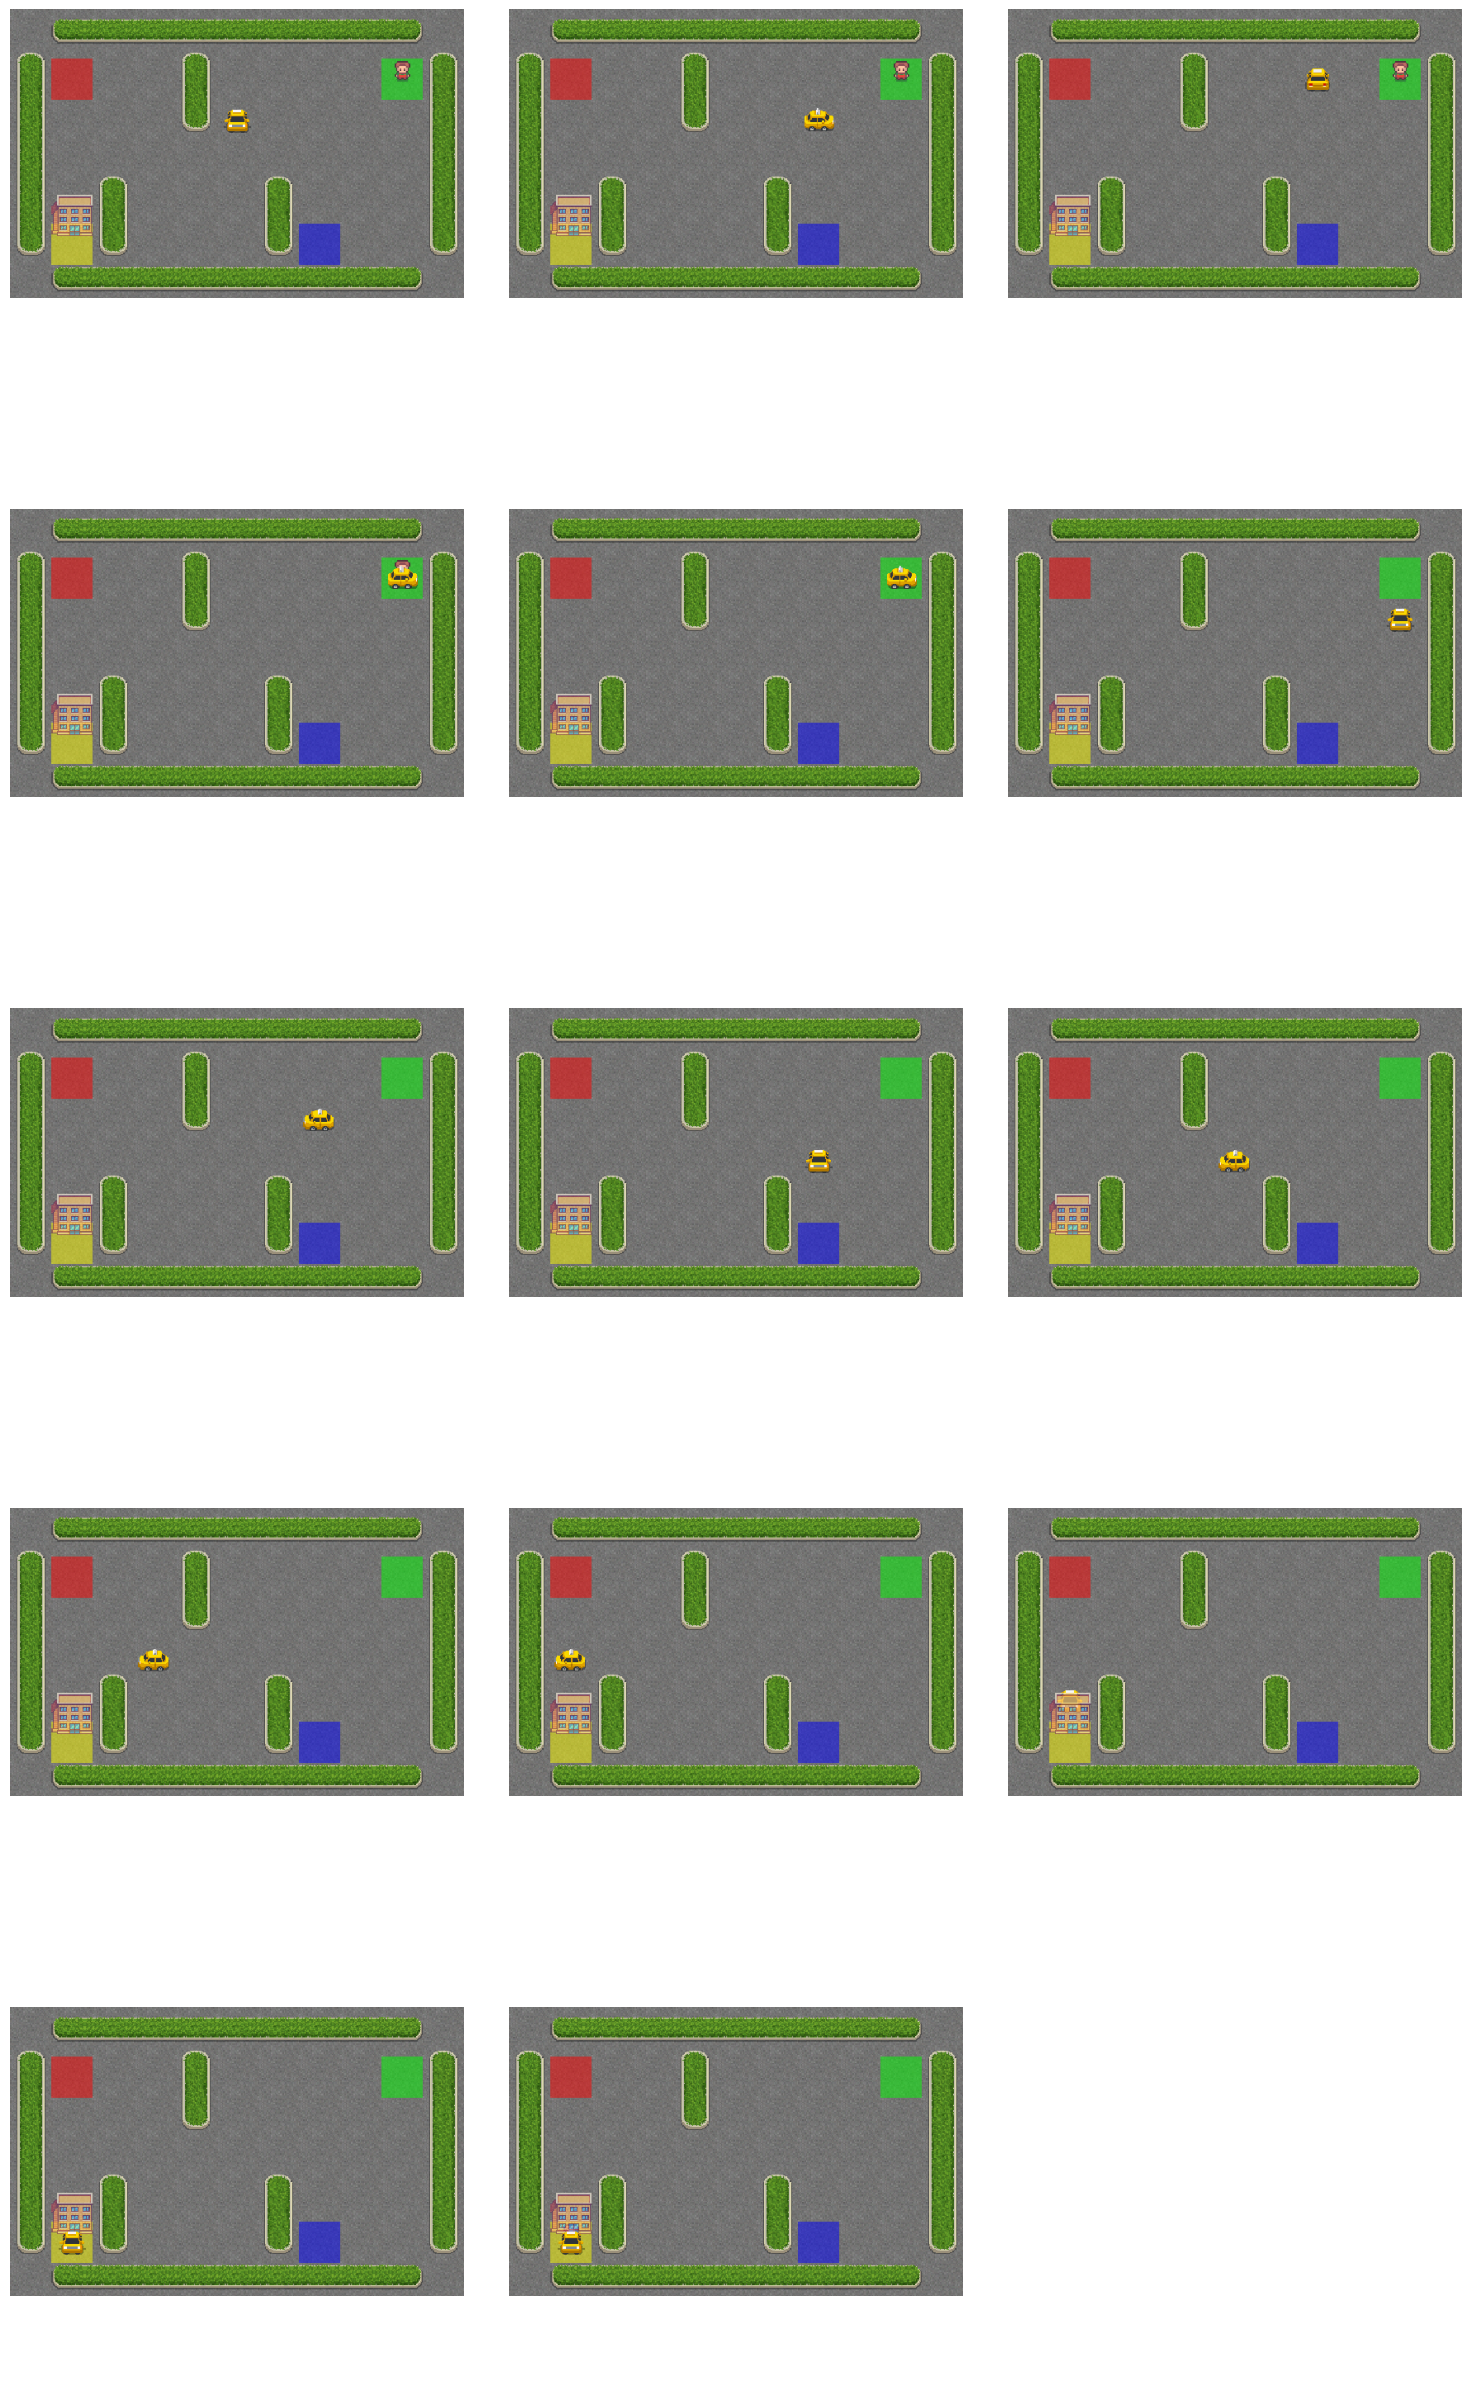

In [11]:
## plot the game
average_reward = evaluate_agent_ql(env
                                , q_table1
                                , episodes=1
                                ,  pPrint=False
                                , pPlotGame=True)
env.close()

### Combining trainings

In [12]:
# Main execution
env = create_env(pGame=GAME_TAXI, pRenderMode=RENDER_RGB, pPrint=True)
q_table = create_q_table(env)


# Train with different parameters and store results
q_table1_3, rewards1 = train_q_learning(env, create_q_table(env), episodes=4000)
q_table2_3, rewards2 = train_q_learning(env, q_table1_3, episodes=4000)
q_table3_3, rewards2 = train_q_learning(env, q_table2_3, episodes=4000)

# Now you have q_table1, q_table2, rewards1, and rewards2 for comparison


[create_env] Creating environment...
[create_env] Environment created successfully!
Episode: 400, Average reward (last 400 episodes): -1.4985505970259796, current epsilon: 0.1
Episode: 800, Average reward (last 400 episodes): -1.327645815048861, current epsilon: 0.1
Episode: 1200, Average reward (last 400 episodes): -1.2340465364796163, current epsilon: 0.1
Episode: 1600, Average reward (last 400 episodes): -1.1516956820398991, current epsilon: 0.1
Episode: 2000, Average reward (last 400 episodes): -1.077171062638149, current epsilon: 0.1
Episode: 2400, Average reward (last 400 episodes): -1.0115852835137442, current epsilon: 0.1
Episode: 2800, Average reward (last 400 episodes): -0.9522171212490023, current epsilon: 0.1
Episode: 3200, Average reward (last 400 episodes): -0.8984836103689672, current epsilon: 0.1
Episode: 3600, Average reward (last 400 episodes): -0.8492816820880772, current epsilon: 0.1
Episode: 4000, Average reward (last 400 episodes): -0.8043307219227944, current eps

In [13]:
## q_table 3 of 3
average_reward = evaluate_agent_ql(env
                                , q_table3_3
                                , episodes=50
                                ,  pPrint=True)

print(f"Average reward: {average_reward}")

Evaluating agent...
Episode [0] [reward]: 15 - [reward/step]: 2.5 - [penalties]: 0 - [total_steps]: 6
Episode [1] [reward]: 6 - [reward/step]: 0.4 - [penalties]: 0 - [total_steps]: 15
Episode [2] [reward]: 4 - [reward/step]: 0.23529411764705882 - [penalties]: 0 - [total_steps]: 17
Episode [3] [reward]: 5 - [reward/step]: 0.3125 - [penalties]: 0 - [total_steps]: 16
Episode [4] [reward]: 6 - [reward/step]: 0.4 - [penalties]: 0 - [total_steps]: 15
Episode [5] [reward]: 5 - [reward/step]: 0.3125 - [penalties]: 0 - [total_steps]: 16
Episode [6] [reward]: 14 - [reward/step]: 2.0 - [penalties]: 0 - [total_steps]: 7
Episode [7] [reward]: 8 - [reward/step]: 0.6153846153846154 - [penalties]: 0 - [total_steps]: 13
Episode [8] [reward]: 7 - [reward/step]: 0.5 - [penalties]: 0 - [total_steps]: 14
Episode [9] [reward]: 8 - [reward/step]: 0.6153846153846154 - [penalties]: 0 - [total_steps]: 13
Episode [10] [reward]: 9 - [reward/step]: 0.75 - [penalties]: 0 - [total_steps]: 12
Episode [11] [reward]: 7

Results after 1 episodes:
len(arr_avg_rewards): 1 
len(arr_total_rewards): 1 
len(arr_total_steps): 1 
len(arr_penalties): 1 


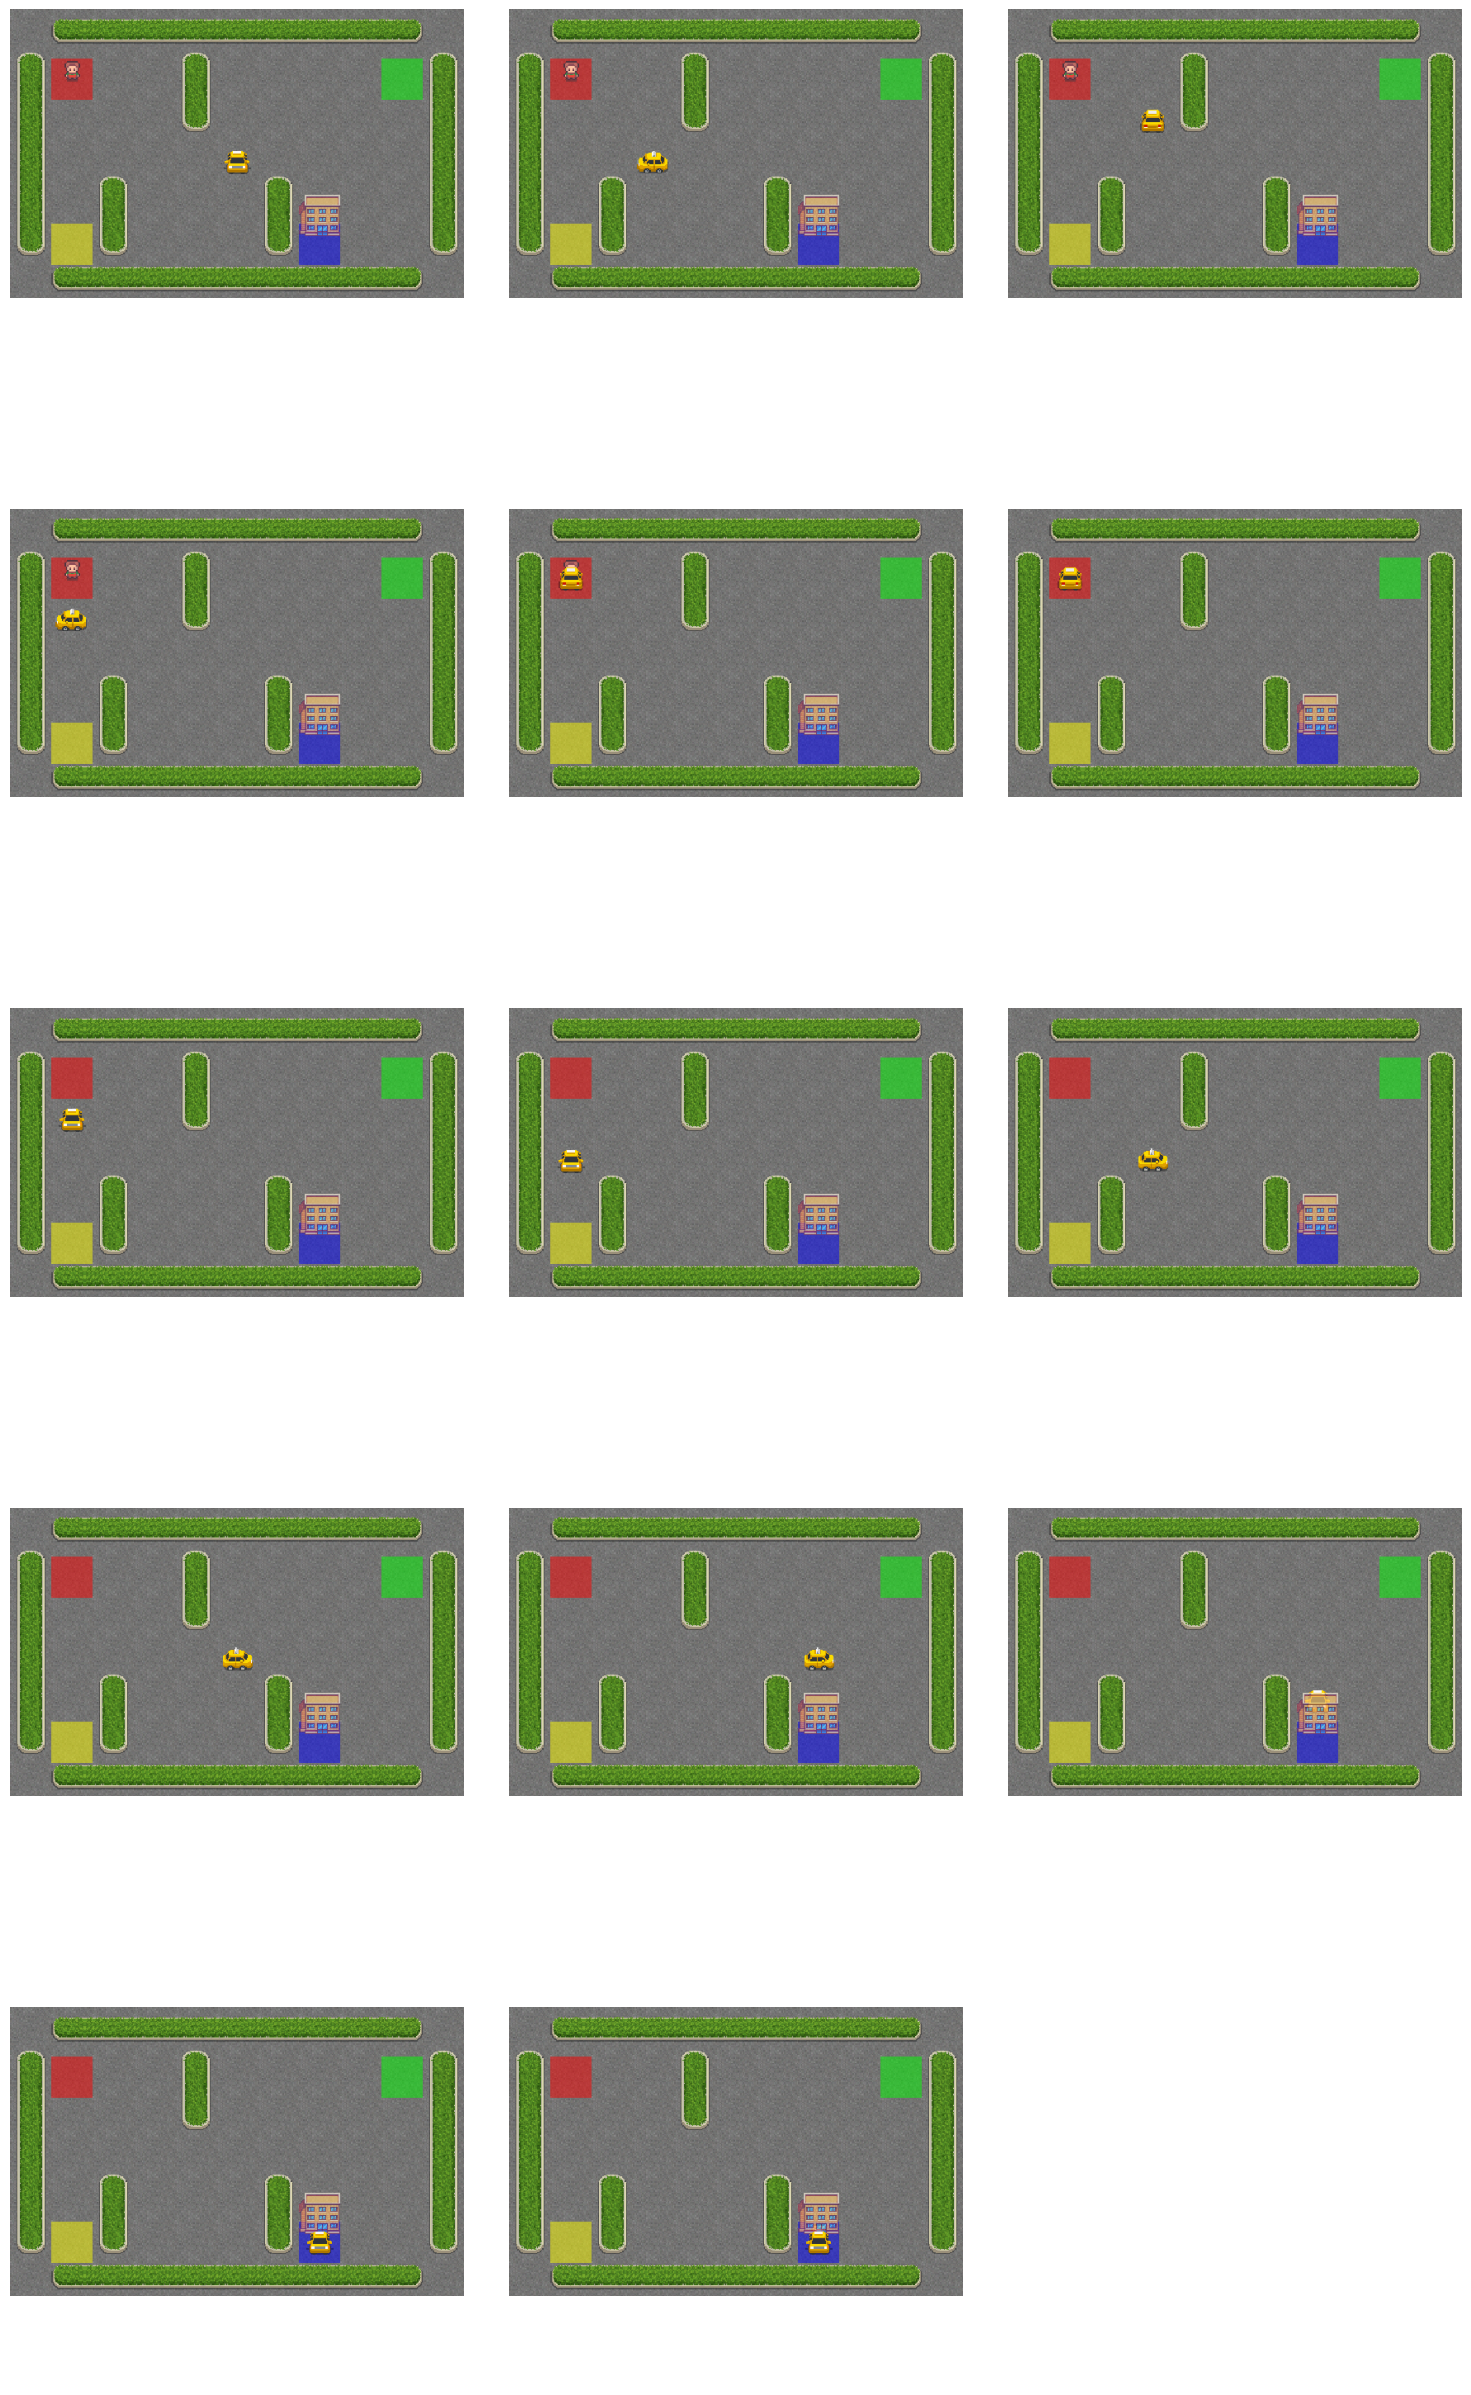

In [14]:
## plot the game
average_reward = evaluate_agent_ql(env
                                , q_table3_3
                                , episodes=1
                                ,  pPrint=False
                                , pPlotGame=True
                                , pDecodeState=True)
env.close()

### Short training

In [15]:
# Main execution
env = create_env(pGame=GAME_TAXI, pRenderMode=RENDER_RGB, pPrint=True)


# Train with different parameters and store results
q_table_short, rewards1 = train_q_learning(env, create_q_table(env), episodes=1000)


[create_env] Creating environment...
[create_env] Environment created successfully!
Episode: 100, Average reward (last 100 episodes): -1.6784034470345526, current epsilon: 0.1
Episode: 200, Average reward (last 100 episodes): -1.480299700744022, current epsilon: 0.1
Episode: 300, Average reward (last 100 episodes): -1.4321352845975424, current epsilon: 0.1
Episode: 400, Average reward (last 100 episodes): -1.3965068954171114, current epsilon: 0.1
Episode: 500, Average reward (last 100 episodes): -1.3683530473472205, current epsilon: 0.1
Episode: 600, Average reward (last 100 episodes): -1.3398282451618297, current epsilon: 0.1
Episode: 700, Average reward (last 100 episodes): -1.3148304102127384, current epsilon: 0.1
Episode: 800, Average reward (last 100 episodes): -1.291325464131715, current epsilon: 0.1
Episode: 900, Average reward (last 100 episodes): -1.2688447640863445, current epsilon: 0.1
Episode: 1000, Average reward (last 100 episodes): -1.2464344237880767, current epsilon: 0

In [16]:
## q_table 1
average_reward = evaluate_agent_ql(env
                                , q_table_short
                                , episodes=50
                                ,  pPrint=True)

print(f"Average reward: {average_reward}")

Evaluating agent...
Episode [0] [reward]: 8 - [reward/step]: 0.6153846153846154 - [penalties]: 0 - [total_steps]: 13
Too many steps 31 Bye !!!
Episode [1] [reward]: -31 - [reward/step]: -1.0 - [penalties]: 0 - [total_steps]: 31
Too many steps 31 Bye !!!
Episode [2] [reward]: -31 - [reward/step]: -1.0 - [penalties]: 0 - [total_steps]: 31
Episode [3] [reward]: 7 - [reward/step]: 0.5 - [penalties]: 0 - [total_steps]: 14
Too many steps 31 Bye !!!
Episode [4] [reward]: -31 - [reward/step]: -1.0 - [penalties]: 0 - [total_steps]: 31
Episode [5] [reward]: 15 - [reward/step]: 2.5 - [penalties]: 0 - [total_steps]: 6
Too many steps 31 Bye !!!
Episode [6] [reward]: -31 - [reward/step]: -1.0 - [penalties]: 0 - [total_steps]: 31
Episode [7] [reward]: 11 - [reward/step]: 1.1 - [penalties]: 0 - [total_steps]: 10
Episode [8] [reward]: 12 - [reward/step]: 1.3333333333333333 - [penalties]: 0 - [total_steps]: 9
Too many steps 31 Bye !!!
Episode [9] [reward]: -31 - [reward/step]: -1.0 - [penalties]: 0 - [t

Evaluating agent...
Too many wrong actions 3. Bye !!!
Episode [0] [reward]: -30 - [reward/step]: -10.0 - [penalties]: 3 - [total_steps]: 3
Results after 1 episodes:
len(arr_avg_rewards): 1 
len(arr_total_rewards): 1 
len(arr_total_steps): 1 
len(arr_penalties): 1 


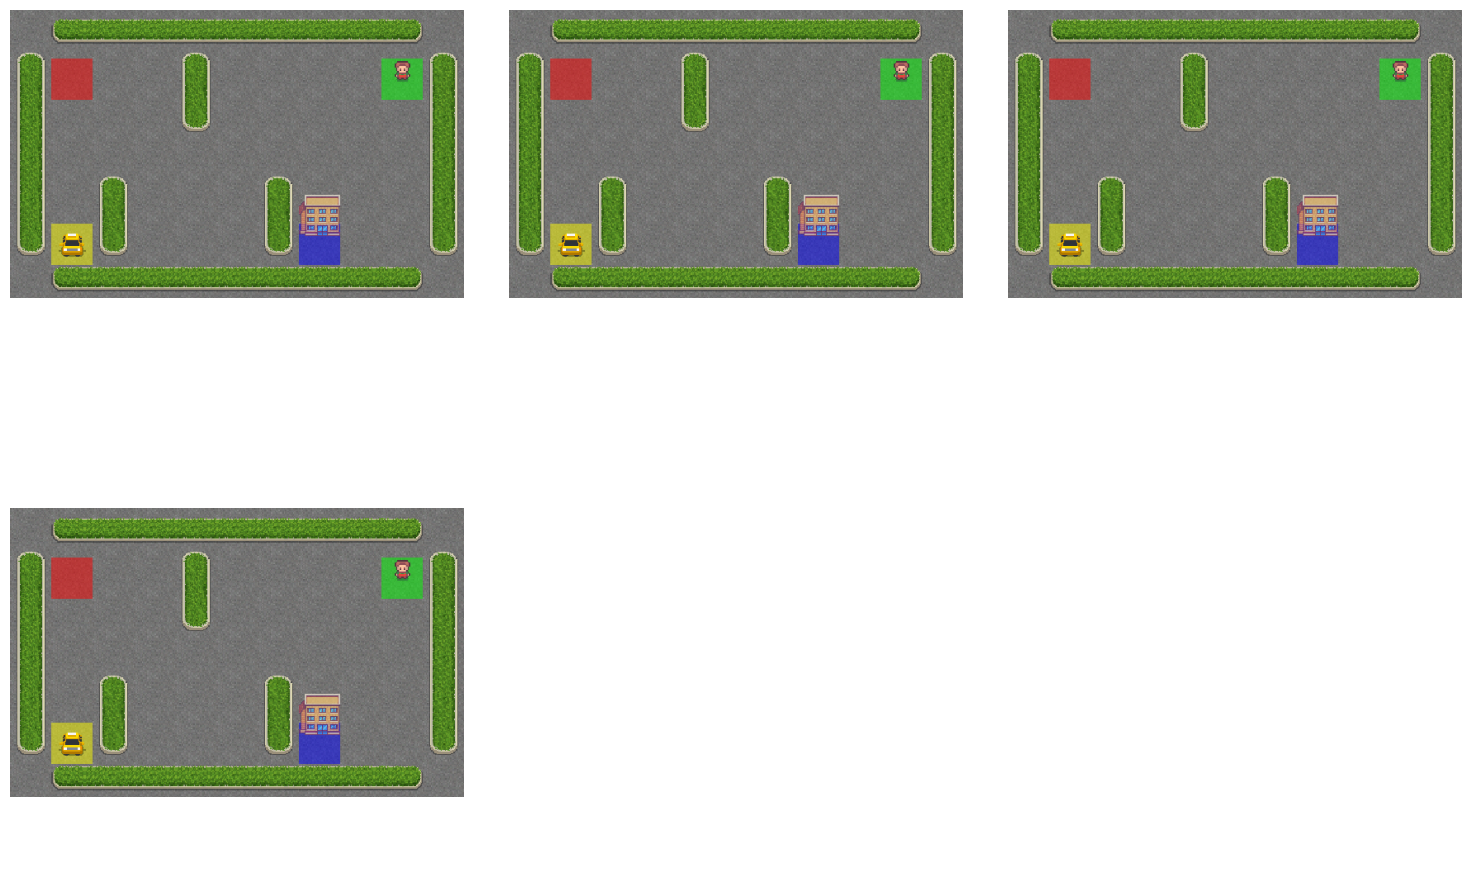

Average reward: -30.0


In [18]:
## q_table_short
average_reward = evaluate_agent_ql(env
                                , q_table_short
                                , episodes=1
                                ,  pPrint=True
                                , pPlotGame=True)

print(f"Average reward: {average_reward}")
env.close()

Not enough training example

# Monte Carlo

In [20]:


## env
env = create_env(pGame=GAME_TAXI, pRenderMode=RENDER_RGB, pPrint=True)

# Initialize Q-table with default values
Q_table = create_q_table(env)

def generate_episode(epsilon, pQTable = Q_table, pPrint=False):
    """Generate an episode and return the list of (state, action, reward)."""
    episode = []
    state, _ = env.reset()  # Reset returns an observation and info; take only the observation
    done = False

    iter_count=0
    rewards = 0

    while not done:
        action = get_policy(pQTable, state, epsilon)  # Use get_policy

        next_state, reward, done, truncated, _ = env.step(action)  # Adjusted for five values

        iter_count+=1

        rewards += reward


        #done = done or truncated or (iter_count>35) or (rewards < -30)
        done = done or truncated #or (iter_count>35) or (rewards < -30)



        if pPrint and iter_count%1000==0:
          print(f"Next State: {next_state}, Reward: {reward}, Done: {done}")  # Debugging print
        episode.append((state, action, reward))
        state = next_state  # Keep state as is

    if pPrint:
      print(f"[gnenerate_episode] Total reward: {rewards}, - stpes: {iter_count}")
    return episode

def update_Q_table(episode, pQTable=Q_table):
    """Update Q-table using the Monte Carlo method based on the episode generated."""
    G = 0  # Initialize return
    visited_state_actions = set()

    # Loop backwards through the episode
    for state, action, reward in reversed(episode):
        G = reward + GAMMA * G
        if (state, action) not in visited_state_actions:
            visited_state_actions.add((state, action))
            # Update Q-table with incremental average
            pQTable[state][action] += (G - pQTable[state][action]) / (1 + np.count_nonzero(pQTable[state]))


def train_monte_carlo_agent(
    pQTable=Q_table
    , pEpisodes=EPISODES
    , pEpsilon=EPSILON_START
    , pEpsilonMin=EPSILON_MIN
    , pEpsilonDecay=EPSILON_DECAY, pPrint=False
):
    """Train the agent using the Monte Carlo method."""
    epsilon = pEpsilon
    total_steps = 0
    total_rewards = 0
    start_time = time.time()

    for episode in range(pEpisodes):
        # Generate an episode and update Q-table
        episode_data = generate_episode(epsilon, pQTable, pPrint)
        update_Q_table(episode_data)

        # Calculate episode-specific stats
        episode_steps = len(episode_data)
        episode_reward = sum([reward for _, _, reward in episode_data])

        # Accumulate total steps and rewards
        total_steps += episode_steps
        total_rewards += episode_reward

        # Decay epsilon after each episode
        epsilon = max(pEpsilonMin, epsilon * pEpsilonDecay)

        # Print progress and elapsed time every 10% of episodes
        if (episode + 1) % int(pEpisodes * 0.1) == 0:
            elapsed_time = time.time() - start_time
            avg_steps = total_steps / (episode + 1)
            avg_reward = total_rewards / (episode + 1)
            print(
                f"Episode {episode + 1}/{pEpisodes} completed. "
                f"Avg steps: {avg_steps:.2f}, Avg reward: {avg_reward:.2f}, "
                f"Time elapsed per episode: {elapsed_time / (episode + 1):.2f} seconds"
            )

    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time:.2f} seconds")
    print(f"Final average steps per episode: {total_steps / pEpisodes:.2f}")
    print(f"Final average reward per episode: {total_rewards / pEpisodes:.2f}")
    print(f"Average time per episode: {total_time / pEpisodes:.2f} seconds")

    return pQTable



def evaluate_agent(pEnv
                   , episodes=100
                   , pQTable=Q_table
                   , pPrint = False
                   , pPlotGame=False



                   ):
    """Evaluate the agent's performance over a number of episodes."""
    total_rewards = 0

    step_count = 0
    penalties = 0

    env = pEnv
    start_time = time.time()

    ### to render game images
    arr_frames = []

    ## current episode
    curr_ep = 0
    for _ in range(episodes):
        state, _ = env.reset()  # Reset returns an observation and info; take only the observation
        done = False
        episode_reward = 0
        curr_ep+=1

        if pPlotGame:
          arr_frames.append(env.render())



        step_count = 0
        penalties = 0
        while not done:
            ## Use the greedy policy since we want to evaluate the learned Q-table
            action = get_policy(pQTable, state=state, epsilon = 0.1)

            ## step
            next_state, reward, done, truncated, info = env.step(action)

            episode_reward += reward
            state = next_state  # Keep state as is
            step_count+=1

            if reward == -10:
              penalties +=1

            if (step_count >29 or penalties >2):
              done=True
              print(f'Too many errors in episode {curr_ep}. Steps: {step_count}, rewards: {episode_reward},  penalties: {penalties} BYE!!!')

            if pPrint:
              print('-------')
              print(f'step_count: {step_count}')
              print(decode_state(state, pPrint=True))

            if pPlotGame:
              arr_frames.append(env.render())




        total_rewards += episode_reward
        if pPrint:
          print(f"Episode [{curr_ep}] [reward]: {episode_reward}, steps: {step_count}")

    avg_reward = total_rewards / episodes
    elapsed_time = time.time() - start_time
    print(f"\nEvaluation completed. Average reward over {episodes} episodes: {avg_reward:.2f}")
    print(f"Time elapsed for evaluation: {elapsed_time:.2f} seconds")
    print(f"Average time per episode: {elapsed_time / episodes:.2f} seconds")

    if pPlotGame:
      plot_frames(arr_frames)






[create_env] Creating environment...
[create_env] Environment created successfully!


## Frist training

In [ ]:
# Run training
env_mc_01 = create_env( pGame=GAME_TAXI, pRenderMode=RENDER_RGB, pPrint=True)

q_tab_mc_01 = train_monte_carlo_agent(pEpisodes=50000
                                      , pEpsilon=1.0
                                      , pEpsilonMin=0.05
                                      , pEpsilonDecay=0.999)



[create_env] Creating environment...
[create_env] Environment created successfully!
Episode 5000/50000 completed. Avg steps: 126.82, Avg reward: -216.05, Time elapsed per episode: 0.00 seconds
Episode 10000/50000 completed. Avg steps: 116.23, Avg reward: -163.28, Time elapsed per episode: 0.00 seconds
Episode 15000/50000 completed. Avg steps: 115.78, Avg reward: -149.71, Time elapsed per episode: 0.00 seconds
Episode 20000/50000 completed. Avg steps: 117.75, Avg reward: -145.43, Time elapsed per episode: 0.00 seconds
Episode 25000/50000 completed. Avg steps: 115.94, Avg reward: -138.98, Time elapsed per episode: 0.00 seconds
Episode 30000/50000 completed. Avg steps: 116.34, Avg reward: -136.74, Time elapsed per episode: 0.00 seconds
Episode 35000/50000 completed. Avg steps: 117.96, Avg reward: -137.01, Time elapsed per episode: 0.00 seconds
Episode 40000/50000 completed. Avg steps: 121.43, Avg reward: -140.02, Time elapsed per episode: 0.00 seconds
Episode 45000/50000 completed. Avg st

## Second training

In [ ]:
q_tab_mc_02 = train_monte_carlo_agent(pEpisodes=50000
                                      , pQTable=q_tab_mc_01
                                      , pEpsilon=1.0
                                      , pEpsilonMin=0.05
                                      , pEpsilonDecay=0.995)

Episode 5000/50000 completed. Avg steps: 140.90, Avg reward: -180.16, Time elapsed per episode: 0.00 seconds
Episode 10000/50000 completed. Avg steps: 130.42, Avg reward: -154.93, Time elapsed per episode: 0.00 seconds
Episode 15000/50000 completed. Avg steps: 125.38, Avg reward: -144.16, Time elapsed per episode: 0.00 seconds
Episode 20000/50000 completed. Avg steps: 127.69, Avg reward: -144.81, Time elapsed per episode: 0.00 seconds
Episode 25000/50000 completed. Avg steps: 131.82, Avg reward: -148.66, Time elapsed per episode: 0.00 seconds
Episode 30000/50000 completed. Avg steps: 134.04, Avg reward: -150.69, Time elapsed per episode: 0.00 seconds
Episode 35000/50000 completed. Avg steps: 139.07, Avg reward: -156.61, Time elapsed per episode: 0.00 seconds
Episode 40000/50000 completed. Avg steps: 142.28, Avg reward: -160.13, Time elapsed per episode: 0.00 seconds
Episode 45000/50000 completed. Avg steps: 143.69, Avg reward: -161.53, Time elapsed per episode: 0.00 seconds
Episode 500

In [ ]:
q_tab_mc_03 = train_monte_carlo_agent(pEpisodes=75000
                                      , pQTable=q_tab_mc_02
                                      , pEpsilon=1.0
                                      , pEpsilonMin=0.05
                                      , pEpsilonDecay=0.999)

Episode 7500/75000 completed. Avg steps: 82.06, Avg reward: -110.95, Time elapsed per episode: 0.00 seconds
Episode 15000/75000 completed. Avg steps: 81.18, Avg reward: -94.32, Time elapsed per episode: 0.00 seconds
Episode 22500/75000 completed. Avg steps: 80.59, Avg reward: -88.46, Time elapsed per episode: 0.00 seconds
Episode 30000/75000 completed. Avg steps: 79.69, Avg reward: -84.80, Time elapsed per episode: 0.00 seconds
Episode 37500/75000 completed. Avg steps: 79.72, Avg reward: -83.27, Time elapsed per episode: 0.00 seconds
Episode 45000/75000 completed. Avg steps: 79.67, Avg reward: -82.19, Time elapsed per episode: 0.00 seconds
Episode 52500/75000 completed. Avg steps: 79.42, Avg reward: -81.13, Time elapsed per episode: 0.00 seconds
Episode 60000/75000 completed. Avg steps: 79.44, Avg reward: -80.60, Time elapsed per episode: 0.00 seconds
Episode 67500/75000 completed. Avg steps: 79.41, Avg reward: -80.14, Time elapsed per episode: 0.00 seconds
Episode 75000/75000 complete

In [ ]:
q_tab_mc_04 = train_monte_carlo_agent(pEpisodes=75000
                                      , pQTable=q_tab_mc_03
                                      , pEpsilon=1.0
                                      , pEpsilonMin=0.1
                                      , pEpsilonDecay=0.995)

Episode 7500/75000 completed. Avg steps: 75.81, Avg reward: -88.35, Time elapsed per episode: 0.00 seconds
Episode 15000/75000 completed. Avg steps: 76.46, Avg reward: -86.57, Time elapsed per episode: 0.00 seconds
Episode 22500/75000 completed. Avg steps: 76.03, Avg reward: -85.06, Time elapsed per episode: 0.00 seconds
Episode 30000/75000 completed. Avg steps: 75.71, Avg reward: -84.18, Time elapsed per episode: 0.00 seconds
Episode 37500/75000 completed. Avg steps: 75.37, Avg reward: -83.40, Time elapsed per episode: 0.00 seconds
Episode 45000/75000 completed. Avg steps: 75.18, Avg reward: -82.99, Time elapsed per episode: 0.00 seconds
Episode 52500/75000 completed. Avg steps: 75.22, Avg reward: -82.88, Time elapsed per episode: 0.00 seconds
Episode 60000/75000 completed. Avg steps: 75.48, Avg reward: -83.14, Time elapsed per episode: 0.00 seconds
Episode 67500/75000 completed. Avg steps: 75.36, Avg reward: -82.89, Time elapsed per episode: 0.00 seconds
Episode 75000/75000 completed

In [ ]:
q_tab_mc_05 = train_monte_carlo_agent(pEpisodes=50000
                                      , pQTable=q_tab_mc_04
                                      , pEpsilon=1.0
                                      , pEpsilonMin=0.1
                                      , pEpsilonDecay=0.991
                                       )

Episode 5000/50000 completed. Avg steps: 75.66, Avg reward: -88.05, Time elapsed per episode: 0.00 seconds
Episode 10000/50000 completed. Avg steps: 75.63, Avg reward: -85.40, Time elapsed per episode: 0.00 seconds
Episode 15000/50000 completed. Avg steps: 76.25, Avg reward: -85.52, Time elapsed per episode: 0.00 seconds
Episode 20000/50000 completed. Avg steps: 75.91, Avg reward: -84.48, Time elapsed per episode: 0.00 seconds
Episode 25000/50000 completed. Avg steps: 76.14, Avg reward: -84.57, Time elapsed per episode: 0.00 seconds
Episode 30000/50000 completed. Avg steps: 75.83, Avg reward: -83.99, Time elapsed per episode: 0.00 seconds
Episode 35000/50000 completed. Avg steps: 75.74, Avg reward: -83.72, Time elapsed per episode: 0.00 seconds
Episode 40000/50000 completed. Avg steps: 75.49, Avg reward: -83.26, Time elapsed per episode: 0.00 seconds
Episode 45000/50000 completed. Avg steps: 75.61, Avg reward: -83.35, Time elapsed per episode: 0.00 seconds
Episode 50000/50000 completed

In [ ]:
q_tab_mc_06 = train_monte_carlo_agent(pEpisodes=250000
                                      , pQTable=q_tab_mc_05
                                      , pEpsilon=1.0
                                      , pEpsilonMin=0.03
                                      , pEpsilonDecay=0.97
                                       )

Episode 25000/250000 completed. Avg steps: 80.92, Avg reward: -74.24, Time elapsed per episode: 0.00 seconds
Episode 50000/250000 completed. Avg steps: 81.50, Avg reward: -74.80, Time elapsed per episode: 0.00 seconds
Episode 75000/250000 completed. Avg steps: 81.97, Avg reward: -75.33, Time elapsed per episode: 0.00 seconds
Episode 100000/250000 completed. Avg steps: 81.93, Avg reward: -75.26, Time elapsed per episode: 0.00 seconds
Episode 125000/250000 completed. Avg steps: 81.99, Avg reward: -75.32, Time elapsed per episode: 0.00 seconds
Episode 150000/250000 completed. Avg steps: 82.07, Avg reward: -75.40, Time elapsed per episode: 0.00 seconds
Episode 175000/250000 completed. Avg steps: 82.02, Avg reward: -75.33, Time elapsed per episode: 0.00 seconds
Episode 200000/250000 completed. Avg steps: 82.08, Avg reward: -75.40, Time elapsed per episode: 0.00 seconds
Episode 225000/250000 completed. Avg steps: 82.17, Avg reward: -75.52, Time elapsed per episode: 0.00 seconds
Episode 25000

In [ ]:
q_tab_mc_07 = train_monte_carlo_agent(pEpisodes=50000
                                      , pQTable=q_tab_mc_06
                                      , pEpsilon=1.0
                                      , pEpsilonMin=0.025
                                      , pEpsilonDecay=0.95
                                       )

Episode 5000/50000 completed. Avg steps: 83.01, Avg reward: -76.46, Time elapsed per episode: 0.00 seconds
Episode 10000/50000 completed. Avg steps: 84.00, Avg reward: -77.08, Time elapsed per episode: 0.00 seconds
Episode 15000/50000 completed. Avg steps: 84.09, Avg reward: -77.06, Time elapsed per episode: 0.00 seconds
Episode 20000/50000 completed. Avg steps: 83.41, Avg reward: -76.16, Time elapsed per episode: 0.00 seconds
Episode 25000/50000 completed. Avg steps: 83.41, Avg reward: -76.10, Time elapsed per episode: 0.00 seconds
Episode 30000/50000 completed. Avg steps: 83.26, Avg reward: -75.89, Time elapsed per episode: 0.00 seconds
Episode 35000/50000 completed. Avg steps: 83.35, Avg reward: -75.96, Time elapsed per episode: 0.00 seconds
Episode 40000/50000 completed. Avg steps: 83.17, Avg reward: -75.73, Time elapsed per episode: 0.00 seconds
Episode 45000/50000 completed. Avg steps: 82.89, Avg reward: -75.38, Time elapsed per episode: 0.00 seconds
Episode 50000/50000 completed

## Saving model

In [ ]:
import pickle

# Save Q-table to a file
with open("/content/q_tab_mc_06.pkl", "wb") as file:
    pickle.dump(q_tab_mc_06, file)



In [ ]:
import os
os.listdir('/content/')

['.config', 'q_tab_mc_02.pkl', 'sample_data']

In [ ]:
## Dwonload
from google.colab import files
files.download("/content/q_tab_mc_02.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Loading model

In [ ]:
## loading model from colab

import pickle

# Load Q-table from the saved file
with open("/content/q_tab_mc_02.pkl", "rb") as file:
    q_tab_mc = pickle.load(file)

## Evaluating agent

In [ ]:
evaluate_agent(pEnv = env_mc_01
               , pQTable=q_tab_mc_06
               ,   episodes=100
               , pPrint=False
               , pPlotGame=False )

Too many errors in episode 1. Steps: 30, rewards: -39,  penalties: 1 BYE!!!
Too many errors in episode 5. Steps: 30, rewards: -39,  penalties: 1 BYE!!!
Too many errors in episode 8. Steps: 30, rewards: -30,  penalties: 0 BYE!!!
Too many errors in episode 12. Steps: 30, rewards: -39,  penalties: 1 BYE!!!
Too many errors in episode 15. Steps: 30, rewards: -48,  penalties: 2 BYE!!!
Too many errors in episode 18. Steps: 30, rewards: -30,  penalties: 0 BYE!!!
Too many errors in episode 21. Steps: 30, rewards: -39,  penalties: 1 BYE!!!
Too many errors in episode 24. Steps: 30, rewards: -57,  penalties: 3 BYE!!!
Too many errors in episode 27. Steps: 7, rewards: -34,  penalties: 3 BYE!!!
Too many errors in episode 28. Steps: 28, rewards: -55,  penalties: 3 BYE!!!
Too many errors in episode 29. Steps: 30, rewards: -30,  penalties: 0 BYE!!!
Too many errors in episode 37. Steps: 30, rewards: -30,  penalties: 0 BYE!!!
Too many errors in episode 44. Steps: 30, rewards: -39,  penalties: 1 BYE!!!
Too

-------
step_count: 1
taxi position: (4, 2) - passenger: (4, 0) - destination: (0, 4)
(4, 2, 2, 1)
-------
step_count: 2
taxi position: (4, 2) - passenger: (4, 0) - destination: (0, 4)
(4, 2, 2, 1)
-------
step_count: 3
taxi position: (4, 2) - passenger: (4, 0) - destination: (0, 4)
(4, 2, 2, 1)
-------
step_count: 4
taxi position: (4, 2) - passenger: (4, 0) - destination: (0, 4)
(4, 2, 2, 1)
-------
step_count: 5
taxi position: (4, 2) - passenger: (4, 0) - destination: (0, 4)
(4, 2, 2, 1)
-------
step_count: 6
taxi position: (4, 2) - passenger: (4, 0) - destination: (0, 4)
(4, 2, 2, 1)
-------
step_count: 7
taxi position: (4, 2) - passenger: (4, 0) - destination: (0, 4)
(4, 2, 2, 1)
-------
step_count: 8
taxi position: (4, 2) - passenger: (4, 0) - destination: (0, 4)
(4, 2, 2, 1)
-------
step_count: 9
taxi position: (4, 2) - passenger: (4, 0) - destination: (0, 4)
(4, 2, 2, 1)
-------
step_count: 10
taxi position: (4, 2) - passenger: (4, 0) - destination: (0, 4)
(4, 2, 2, 1)
-------
s

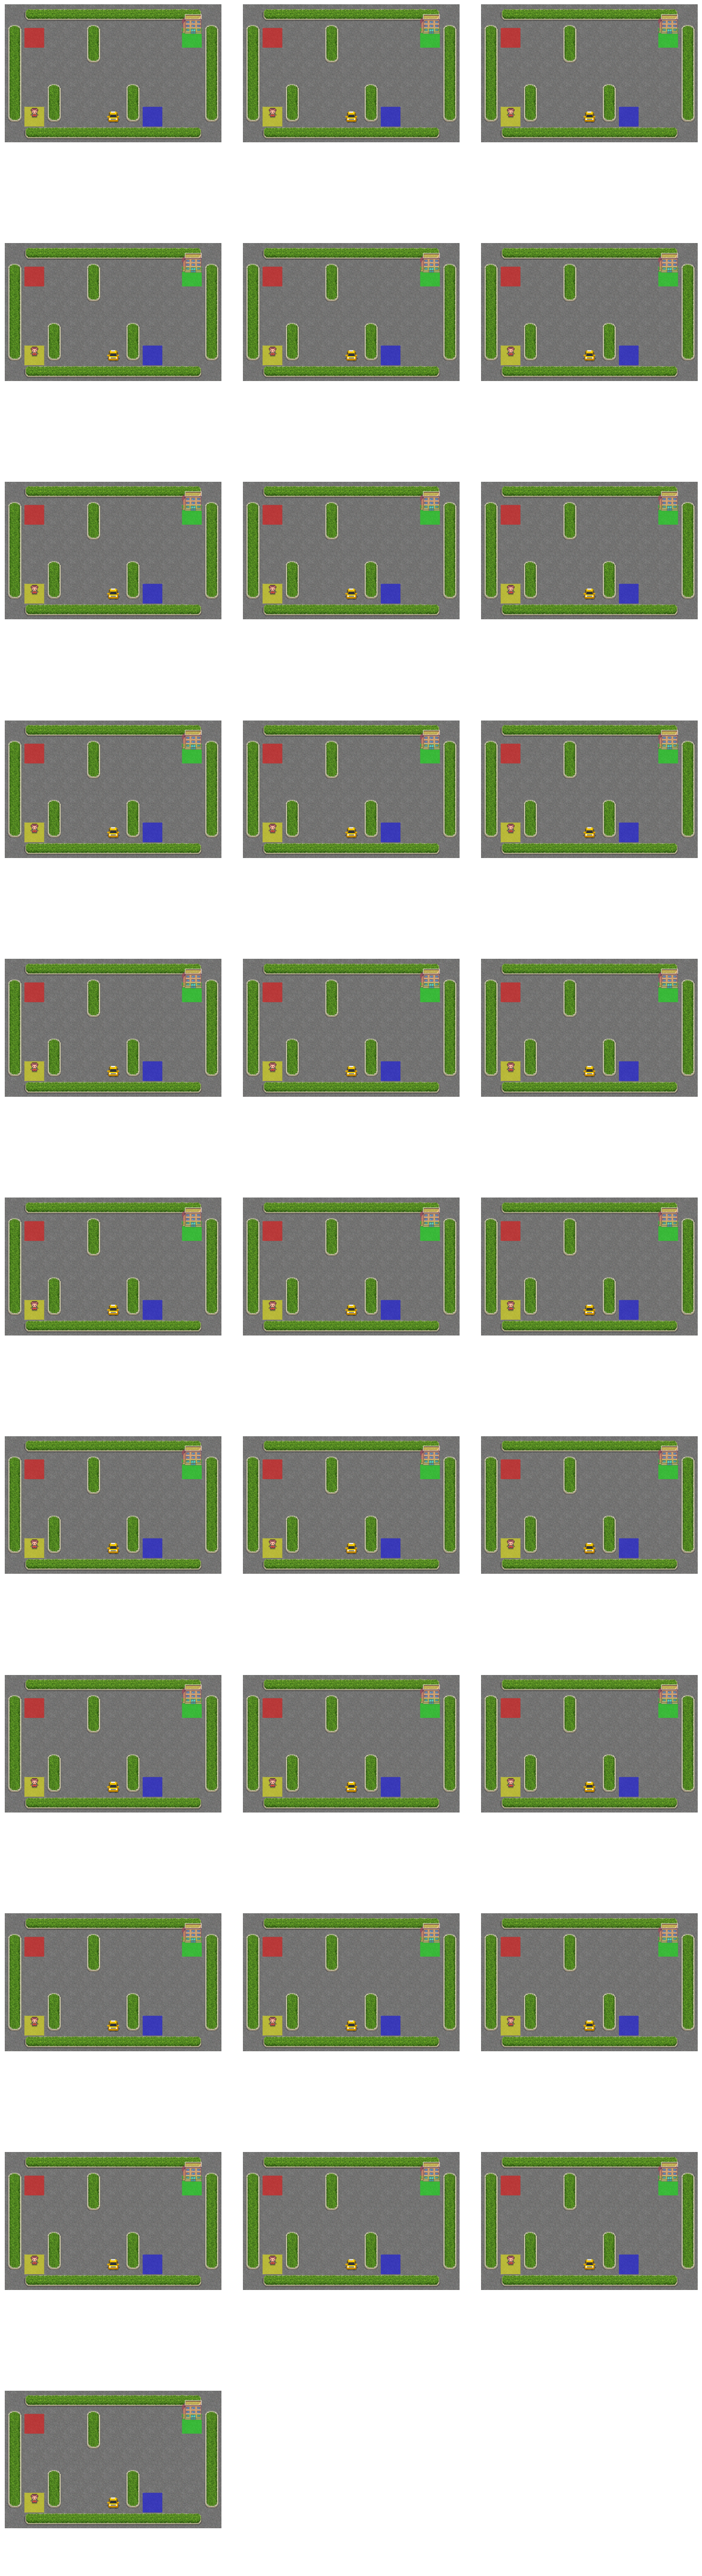

In [ ]:
evaluate_agent(pEnv = env_mc_01
               , pQTable=q_tab_mc_05
               ,   episodes=1
               , pPrint=True
               , pPlotGame=True )

In [ ]:
env_mc_01 = create_env( pGame=GAME_TAXI, pRenderMode=RENDER_RGB, pPrint=True)

[create_env] Creating environment...
[create_env] Environment created successfully!


In [ ]:

evaluate_agent(pEnv = env_mc_01
               , pQTable=q_tab_mc
               ,   episodes=1
               , pPrint=True
               , pPlotGame=True )
env_mc_01.close()

-------
iter: {'prob': 1.0, 'action_mask': array([1, 1, 1, 0, 0, 0], dtype=int8)}
taxi position: (1, 2) - passenger: (4, 0) - destination: (4, 4)
(1, 2, 2, 3)


KeyboardInterrupt: 

In [ ]:
env_mc_01_15k = create_env( pGame=GAME_TAXI, pRenderMode=RENDER_RGB, pPrint=True)

q_tab_mc_15k = train_monte_carlo_agent(pEpisodes=15000)

[create_env] Creating environment...
[create_env] Environment created successfully!
Episode 1500/15000 completed. Time elapsed: 90.26 seconds
Episode 3000/15000 completed. Time elapsed: 181.99 seconds
Episode 4500/15000 completed. Time elapsed: 273.48 seconds
Episode 6000/15000 completed. Time elapsed: 361.86 seconds
Episode 7500/15000 completed. Time elapsed: 453.83 seconds
Episode 9000/15000 completed. Time elapsed: 542.51 seconds
Episode 10500/15000 completed. Time elapsed: 630.03 seconds
Episode 12000/15000 completed. Time elapsed: 720.45 seconds
Episode 13500/15000 completed. Time elapsed: 807.06 seconds
Episode 15000/15000 completed. Time elapsed: 897.20 seconds

Training completed in 897.20 seconds


In [ ]:
evaluate_agent(pEnv = env_mc_01_15k, pQTable=q_tab_mc_15k,   episodes=100)


Evaluation completed. Average reward over 100 episodes: -10804.86
Time elapsed for evaluation: 7.03 seconds


In [ ]:
q_tab_mc_15k

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [-32.96045736, -32.72716229, -32.02935379, -33.25547173,
        -34.47469138, -38.39931576],
       [-35.71015771, -28.91541678, -29.5336324 , -32.32571603,
        -30.15847707, -38.4752392 ],
       ...,
       [-37.21430658, -37.34506986, -36.93834814, -30.59067884,
        -40.62109872, -36.78383007],
       [-32.934117  , -38.42941226, -32.72276212, -31.64394995,
        -36.11994084, -39.57804148],
       [-19.35882117, -23.23599714, -17.60183251,   0.72333318,
        -28.78431563, -26.27131875]])

In [ ]:
q_tab_mc_15k = train_monte_carlo_agent(pEpisodes=5000, pQTable=q_tab_mc_15k)

Episode 500/5000 completed. Time elapsed: 27.36 seconds
Episode 1000/5000 completed. Time elapsed: 57.03 seconds
Episode 1500/5000 completed. Time elapsed: 84.77 seconds
Episode 2000/5000 completed. Time elapsed: 113.54 seconds
Episode 2500/5000 completed. Time elapsed: 138.61 seconds
Episode 3000/5000 completed. Time elapsed: 168.29 seconds
Episode 3500/5000 completed. Time elapsed: 197.66 seconds
Episode 4000/5000 completed. Time elapsed: 227.31 seconds
Episode 4500/5000 completed. Time elapsed: 257.86 seconds
Episode 5000/5000 completed. Time elapsed: 292.18 seconds

Training completed in 292.18 seconds


In [ ]:
evaluate_agent(pEnv = env_mc_01_15k, pQTable=q_tab_mc_15k,   episodes=100)


Evaluation completed. Average reward over 100 episodes: -10460.54
Time elapsed for evaluation: 6.94 seconds


In [ ]:
# Run training
env_mc_02 = create_env( pGame=GAME_TAXI, pRenderMode=RENDER_RGB, pPrint=True)

q_tab_mc_01 = train_monte_carlo_agent(pEpisodes=100)
q_tab_mc_02 = train_monte_carlo_agent(pEpisodes=100, pQTable=q_tab_mc_01)
q_tab_mc_03 = train_monte_carlo_agent(pEpisodes=100, pQTable=q_tab_mc_02)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[create_env] Creating environment...
[create_env] Environment created successfully!
Episode 10/100 completed. Time elapsed: 0.68 seconds
Episode 20/100 completed. Time elapsed: 1.12 seconds
Episode 30/100 completed. Time elapsed: 1.51 seconds
Episode 40/100 completed. Time elapsed: 2.02 seconds
Episode 50/100 completed. Time elapsed: 2.87 seconds
Episode 60/100 completed. Time elapsed: 3.84 seconds
Episode 70/100 completed. Time elapsed: 4.53 seconds
Episode 80/100 completed. Time elapsed: 4.98 seconds
Episode 90/100 completed. Time elapsed: 5.45 seconds
Episode 100/100 completed. Time elapsed: 6.11 seconds

Training completed in 6.12 seconds
Episode 10/100 completed. Time elapsed: 0.31 seconds
Episode 20/100 completed. Time elapsed: 0.78 seconds
Episode 30/100 completed. Time elapsed: 1.38 seconds
Episode 40/100 completed. Time elapsed: 2.09 seconds
Episode 50/100 completed. Time elapsed: 2.72 seconds
Episode 60/100 completed. Time elapsed: 3.42 seconds
Episode 70/100 completed. Time 

In [ ]:
# Evaluate the trained agent
evaluate_agent(pEnv = env_mc_02, pQTable=q_tab_mc_03,   episodes=100)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Evaluation completed. Average reward over 100 episodes: -10672.11
Time elapsed for evaluation: 7.05 seconds
